### ANÁLISE E PREVISÃO DA ARRECADAÇÃO FEDERAL

Autor: GABRIEL RODRIGUES  MARCOLINI

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Define parâmetros iniciais
dataset_path = '.\\dataset\\CSV\\'
filename_input = 'arrecadacao-TOTAL-GERAL-2015-2020.csv'
indicadores = 'xgdvConsulta.csv'

In [3]:
#Faz a leitura dos datasets
#tb = tabela de Arrecadação Federal
#ie = tabela de indicadores econômicos
tb = pd.read_csv(dataset_path+filename_input) 
ie = pd.read_csv(dataset_path+indicadores,sep=';',decimal=',')

In [4]:
#Ajusta o campo DATA do dataframe ie
ie['DATA'] =  pd.to_datetime(ie['DATA'],format="%m/%Y") + pd.tseries.offsets.MonthEnd(0)
ie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATA    66 non-null     datetime64[ns]
 1   IGP-M   66 non-null     float64       
 2   IPCA    66 non-null     float64       
 3   INPC    66 non-null     float64       
 4   SELIC   66 non-null     float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 2.7 KB


In [5]:
#Ajusta o campo DATA do dataframe tb
tb['DATA'] = pd.to_datetime(tb['DATA'],format="%Y/%m/%d")
tb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1782 entries, 0 to 1781
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   RECEITAS  1782 non-null   object        
 1   UF        1782 non-null   object        
 2   VALOR     1782 non-null   float64       
 3   DATA      1782 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 55.8+ KB


In [6]:
ie

,DATA,IGP-M,IPCA,INPC,SELIC
0,2015-01-31,0.76,1.24,1.48,0.94
1,2015-02-28,0.27,1.22,1.16,0.82
2,2015-03-31,0.98,1.32,1.51,1.04
3,2015-04-30,1.17,0.71,0.71,0.95
4,2015-05-31,0.41,0.74,0.99,0.99
...,...,...,...,...,...
61,2020-02-29,-0.04,0.25,0.17,0.29
62,2020-03-31,1.24,0.07,0.18,0.34
63,2020-04-30,0.80,-0.31,-0.23,0.28
64,2020-05-31,0.28,-0.38,-0.25,0.24


In [7]:
#Unindo os dataframes tb + ie
left = tb.groupby([tb['DATA']]).sum()
right = ie
result = pd.merge(left,right,how='inner',on='DATA')
result

,DATA,VALOR,IGP-M,IPCA,INPC,SELIC
0,2015-01-31,1.252819e+11,0.76,1.24,1.48,0.94
1,2015-02-28,8.998163e+10,0.27,1.22,1.16,0.82
2,2015-03-31,9.411215e+10,0.98,1.32,1.51,1.04
3,2015-04-30,1.092412e+11,1.17,0.71,0.71,0.95
4,2015-05-31,9.150023e+10,0.41,0.74,0.99,0.99
...,...,...,...,...,...,...
61,2020-02-29,1.164304e+11,-0.04,0.25,0.17,0.29
62,2020-03-31,1.097175e+11,1.24,0.07,0.18,0.34
63,2020-04-30,1.011542e+11,0.80,-0.31,-0.23,0.28
64,2020-05-31,7.741535e+10,0.28,-0.38,-0.25,0.24


In [8]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 0 to 65
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATA    66 non-null     datetime64[ns]
 1   VALOR   66 non-null     float64       
 2   IGP-M   66 non-null     float64       
 3   IPCA    66 non-null     float64       
 4   INPC    66 non-null     float64       
 5   SELIC   66 non-null     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 3.6 KB


In [9]:
# Criando um novo DF para tratar os desvios de arrecadação (outliers) observados em 10/2016 e 04, 05 e 06/2020.
# Os valores serão substitudo pelo valor arrecadado no mesmo mês do ano anterior. 
#outliers = ['2016-10-31','2020-04-30','2020-05-31','2020-06-30']

result_n = result.copy()

result_n.loc[(result_n['DATA'] == '2016-10-31'),'VALOR'] = result_n.loc[(result_n['DATA'] == '2015-10-31'),'VALOR'].values
result_n.loc[(result_n['DATA'] == '2020-04-30'),'VALOR'] = result_n.loc[(result_n['DATA'] == '2019-04-30'),'VALOR'].values
result_n.loc[(result_n['DATA'] == '2020-05-31'),'VALOR'] = result_n.loc[(result_n['DATA'] == '2019-05-31'),'VALOR'].values
result_n.loc[(result_n['DATA'] == '2020-06-30'),'VALOR'] = result_n.loc[(result_n['DATA'] == '2019-06-30'),'VALOR'].values

In [10]:
#Define função para calcular o MAPE - Mean Absolute Percentage Error
def mape(y_pred,y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [11]:
#Calculo de juros acumulados
def juros_acumulados(t):
    juros = 1
    for i in range(len(t)):
        juros = juros * (1+(t[i]/100))
    
    juros = (juros-1)*100
    return juros

In [12]:
def corrige_valor_por_indicador_economico(DataFrame,indicador,tipo_juros='composto'):
# Aplica o Indice acumulado sobre o valor arrecadado no mesmo mês do ano anterior. 
# Nos primeiros 12 meses da série, o valor previsto é igual ao valor real. 
# - tipo_juros: 'simples' ou 'composto'
    valor_real, valor_previsto, valor_base, fator = [], [], [], []
    end = DataFrame.shape[0]
    for n in range(end):
        i = n-12
        if i < 0: i = 0
        j = n-1
        if j < 0: j = 0
        k = n-12
        if k < 0: k = n
        valor_real.append(DataFrame['VALOR'].iat[n]) # Valor efetivamente arrecadado
        valor_base.append(DataFrame['VALOR'].iat[k])  # Valor base para a previsão
        if n < 12: # Nos primeiros 12 meses da série, os indicadores econômicos são iguais a 0
            indice = [0]
        else: #Obtém Indicadores Economicos dos ultimos 12 meses
            indice = DataFrame[indicador].iloc[i:j].values
        if tipo_juros == 'simples':
            fator_correcao = 1+(np.sum(indice)/100)
        elif tipo_juros == 'composto':
            fator_correcao = 1+(juros_acumulados(indice)/100)
        fator.append(fator_correcao)
        valor_previsto.append(DataFrame['VALOR'].iat[k] * fator_correcao)
    return  np.array(valor_previsto), np.array(valor_base), np.array(fator), np.array(valor_real)

In [13]:
def corrige_valor_por_fator_med_mov(DataFrame,nper=1):
#Protótipo de modelo com base na criação de um fator de multiplicação baseado na média móvel da divisão 
# entre o valor arrecadado no mês anterior (n-(y+1)) e o valor arrecadado no mesmo mês do ano anterior 
#(n-(y+13)) para 'nper' períodos
# - nper = nº de periodos para calcular a média móvel do fator_mm
    valor_real, valor_previsto, valor_base, fator = [], [], [], []
    end = DataFrame.shape[0]
    for n in range(end):
        i = n-12
        if i < 0: i = 0
        j = n-1
        if j < 0: j = 0
        k = n-12
        if k < 0: k = n
        valor_real.append(DataFrame['VALOR'].iat[n]) # Valor efetivamente arrecadado
        valor_base.append(DataFrame['VALOR'].iat[k]) # Valor base para a previsão
        fator_mm = []
        for y in range(nper):
            fator_mm.append(DataFrame['VALOR'].iat[n-(y+1)] / DataFrame['VALOR'].iat[n-(y+13)])
        fator_mm = np.mean(fator_mm)
        if n < (12+(nper)): fator_mm = 1
        #Nos primeiros 12+nper meses da série, o valor corrigido é igual ao valor corrente. 
        valor_previsto.append(DataFrame['VALOR'].iat[k] * fator_mm)
        fator.append(fator_mm)
    return  np.array(valor_previsto), np.array(valor_base), np.array(fator), np.array(valor_real)

In [14]:
# Buscando o melhor nper para a média móvel com base no MAPE
valor_n = np.array(result_n['VALOR'])
melhor_mape = 1000
for x in range(12):
    valor_fator_mm_n, _, _, _ = corrige_valor_por_fator_med_mov(result_n,x)
    teste = mape(valor_fator_mm_n,valor_n)
    if teste < melhor_mape:
        melhor_mape = teste
        melhor_x = x
print("Melhor valor 'nper' para média móvel = %.1f / Melhor MAPE= %.4f'" %(melhor_x, melhor_mape))

Melhor valor 'nper' para média móvel = 3.0 / Melhor MAPE= 2.2095'


C:\Users\grmar\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\grmar\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
# Obtendo os valores
# SELIC = Juros Simples / IGP-M, IPCA e INPC = Juros Compostos
valor_real = np.array(result['VALOR']) #Dataset original
valor_n = np.array(result_n['VALOR']) #Dataset com valores substituidos
valor_igpm12, _, _, _ = corrige_valor_por_indicador_economico(result,'IGP-M')
valor_igpm12_n, _, _, _ = corrige_valor_por_indicador_economico(result_n,'IGP-M')
valor_ipca12, _, _, _ = corrige_valor_por_indicador_economico(result,'IPCA')
valor_ipca12_n, _, _, _ = corrige_valor_por_indicador_economico(result_n,'IPCA')
valor_inpc12, _, _, _ = corrige_valor_por_indicador_economico(result,'INPC')
valor_inpc12_n, _, _, _ = corrige_valor_por_indicador_economico(result_n,'INPC')
valor_selic12, _, _, _ = corrige_valor_por_indicador_economico(result,'SELIC','simples')
valor_selic12_n, _, _, _ = corrige_valor_por_indicador_economico(result_n,'SELIC','simples')
valor_fator_mm, _, _, _ = corrige_valor_por_fator_med_mov(result,3)
valor_fator_mm_n, _, _, _ = corrige_valor_por_fator_med_mov(result_n,3)

In [16]:
#Comparando os modelos através do MAPE
print('\nMean Absolute Percentage Error')
print('                REAL    /  NORMAL')
print('IGP-M         - %.4f  /  %.4f' %(mape(valor_igpm12,valor_real), mape(valor_igpm12_n,valor_n)))
print('IPCA          - %.4f  /  %.4f' %(mape(valor_ipca12,valor_real), mape(valor_ipca12_n,valor_n)))
print('INPC          - %.4f  /  %.4f' %(mape(valor_inpc12,valor_real), mape(valor_inpc12_n,valor_n)))
print('SELIC         - %.4f  /  %.4f' %(mape(valor_selic12,valor_real),mape(valor_selic12_n,valor_n)))
print('Fator Med Mov - %.4f  /  %.4f' %(mape(valor_fator_mm,valor_real), mape(valor_fator_mm_n,valor_n)))


Mean Absolute Percentage Error
                REAL    /  NORMAL
IGP-M         - 6.9839  /  4.7586
IPCA          - 6.0178  /  3.6622
INPC          - 6.2260  /  3.9111
SELIC         - 6.5811  /  4.0344
Fator Med Mov - 4.8899  /  2.2095


In [17]:
# Ajustar parâmetros de plotagem
#plt.rcParams.keys()
plt.rcParams["text.color"] = 'Blue'
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["figure.figsize"] = [15, 6]
plt.rcParams["lines.linewidth"] = 2.0

In [18]:
# Transforma os arrays em séria e adiciona o índice DATA
valor_n = pd.Series(valor_n, index=result_n['DATA'])
valor_ipca12_n = pd.Series(valor_ipca12_n, index=result_n['DATA'])
valor_fator_mm_n = pd.Series(valor_fator_mm_n, index=result_n['DATA'])

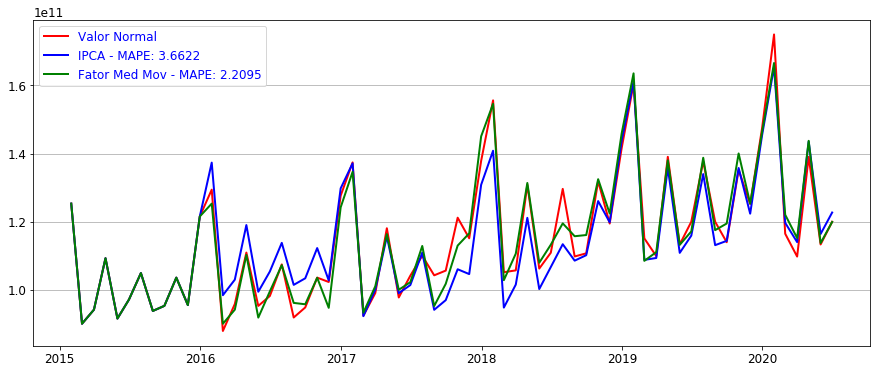

In [19]:
#Pltotando um gráfico comparativo 
plt.plot(valor_n, color = 'red', label = 'Valor Normal')
plt.plot(valor_ipca12_n, color = 'blue', label = 'IPCA - MAPE: %.4f' % mape(valor_ipca12_n,valor_n))
plt.plot(valor_fator_mm_n, color = 'green', label = 'Fator Med Mov - MAPE: %.4f' % mape(valor_fator_mm_n,valor_n))
plt.legend()
plt.grid(True,axis='y')
plt.legend(loc='best')

In [20]:
#Separando uma base de testes
teste = valor_n[-18:]
ipca_teste = valor_ipca12_n[-18:]
fatormm_teste = valor_fator_mm_n[-18:]

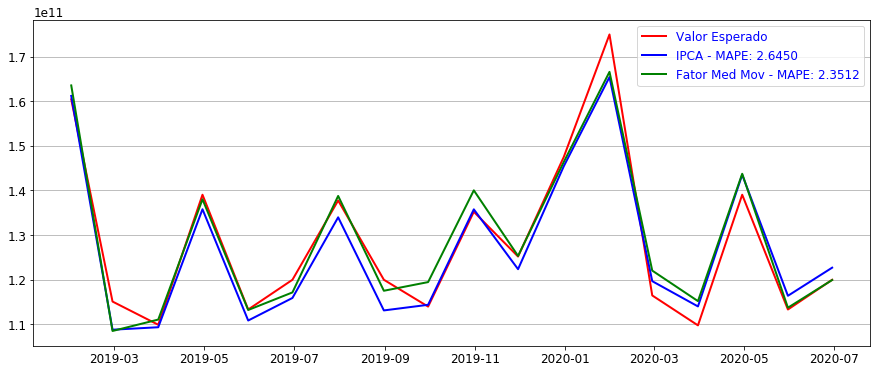

In [21]:
# Comparando o desempenho dos indicadores como valor real
plt.plot(teste, color = 'red', label = 'Valor Esperado')
plt.plot(ipca_teste, color = 'blue', label = 'IPCA - MAPE: %.4f' % mape(ipca_teste,teste))
plt.plot(fatormm_teste, color = 'green', label = 'Fator Med Mov - MAPE: %.4f' % mape(fatormm_teste,teste))
plt.legend()
plt.grid(True,axis='y')
plt.legend(loc='best')